In [282]:
from pathlib import Path
from typing import List, Tuple, Optional, Union
from pydantic import BaseModel
from enum import Enum
import os
from joblib import Parallel, delayed
import dataclasses
from dataclasses import dataclass
import itertools
import numpy as np
import matplotlib.pyplot as plt
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale, Normalizer, normalize

import importlib
import modeling
importlib.reload(modeling)
import modeling.riscv_dv as riscv_dv
importlib.reload(modeling.riscv_dv)
import modeling.coverage_parser as coverage_parser
importlib.reload(modeling.coverage_parser)

<module 'modeling.coverage_parser' from '/nscratch/vighneshiyer/cov-proxy-model/modeling/coverage_parser.py'>

In [2]:
class Timeout:
    pass
@dataclass
class Pass:
    pass_cycles: int
@dataclass
class Fail:
    fail_cycles: Optional[int] # None = failed for unknown reason (e.g. bad syscall), int = failed due to timeout in given cycles
    
@dataclass
class TestData:
    config: riscv_dv.RiscvDvConfig
    cov_data: Optional[List[coverage_parser.cov_t]]
    spike_status: Optional[int]  # None = timeout, int value = number of lines of spike.log (roughly correlated with number of instructions executed)
    rtl_sim_status: Union[Pass, Fail] # pass: cycles, fail: timeout and cycles, fail: no reason
    test_id: int
    test_iteration: int
    
def read_last_line(file: Path) -> str:
    with open(file, 'rb') as f:
        try:  # catch OSError in case of a one line file 
            f.seek(-2, os.SEEK_END)
            while f.read(1) != b'\n':
                f.seek(-2, os.SEEK_CUR)
        except OSError:
            f.seek(0)
        last_line = f.readline().decode()
    return last_line

def clean_test_data(data: TestData) -> Optional[TestData]:
    if not data.cov_data:
        return None  # discard data points without coverage data
    if isinstance(data.rtl_sim_status, Fail) and data.rtl_sim_status.fail_cycles is None:
        return None  # discard data points that fail for no obvious reason
    
    # remove coverage points with 'block' coverage type
    cov_data = [x for x in data.cov_data if x[3] != "block"]
    
    # normalize coverage points by cycle count
    if hasattr(data.rtl_sim_status, "pass_cycles"):
        cov_data = [(x[0], x[1], x[2], x[3], x[4], float(x[5]) / float(data.rtl_sim_status.pass_cycles)) for x in cov_data]
    elif hasattr(data.rtl_sim_status, "fail_cycles"): # include failing tests as long as the test simply timed out
        cov_data = [(x[0], x[1], x[2], x[3], x[4], float(x[5]) / float(data.rtl_sim_status.fail_cycles)) for x in cov_data]
    else:
        print(data.rtl_sim_status)
        assert False
        
    cov_data.sort(key=lambda c: (c[0], c[1], c[3])) # sort by file, then by line number, then by type (if vs else)
    
    return dataclasses.replace(data, cov_data=cov_data)

In [3]:
def parse_test(test_id_folder: Path) -> List[TestData]:
    # Figure out how many iterations were run for a given test id, look at the maximum number of file names
    n_iterations: int = int(max([x.name.split('.')[0] for x in test_id_folder.iterdir()])[0])
    test_data: List[TestData] = []
    print(f"Parsing test {test_id_folder}")
    for i in range(n_iterations+1):
        riscv_dv_config = riscv_dv.RiscvDvConfig.parse_raw((test_id_folder / f"{i}.json").read_text())
        
        cov_dat_file = (test_id_folder / f"{i}.cov.dat")
        if cov_dat_file.exists():
            cov_data = [coverage_parser.parse_line(line) for line in cov_dat_file.read_text().split('\n')[1:] if len(line) != 0]
        else:
            cov_data = None
        
        spike_status_str = (test_id_folder / f"{i}.spike.status").read_text()
        if spike_status_str == "TIMEOUT":
            spike_status = None
        else:
            spike_status = int(spike_status_str)
            
        sim_log_file = (test_id_folder / f"{i}.sim.log")
        sim_log_str = read_last_line(sim_log_file)
        if sim_log_str.startswith("*** PASSED ***"):
            rtl_sim_status = Pass(pass_cycles=int(sim_log_str.split(' ')[5]))
        elif sim_log_str.startswith("*** FAILED *** via trace_count"):
            rtl_sim_status = Fail(fail_cycles=int(sim_log_str.split(' ')[9]))
        else:
            rtl_sim_status = Fail(fail_cycles=None)
        test_data.append(TestData(config=riscv_dv_config, cov_data=cov_data, spike_status=spike_status, rtl_sim_status=rtl_sim_status, test_id=test_id_folder.name, test_iteration=i))
    return test_data

In [4]:
# Get coverage data and riscv-dv configs for each test
data = Parallel(n_jobs=24)(delayed(parse_test)(test_id_folder) for test_id_folder in (Path.cwd() / "configs").iterdir())
len(data)

100

In [5]:
data = list(itertools.chain(*data))

In [7]:
cleaned_data = [clean_test_data(d) for d in data]
cleaned_data = [x for x in cleaned_data if x is not None]

In [43]:
def data_to_vector(data: TestData) -> Tuple[List[float], List[float]]: # returns a row of the A matrix and a row of the B matrix
    keys = [x for x in data.config.plusarg_config.keys() if x != "boot_mode"]
    keys.sort()
    A = [float(data.config.plusarg_config[key]) for key in keys]
    
    B = [float(d[5]) for d in data.cov_data]
    
    return A, B

In [44]:
sampleA, sampleB = data_to_vector(cleaned_data[0])
A = np.zeros((len(cleaned_data), len(sampleA)))
B = np.zeros((len(cleaned_data), len(sampleB)))
for i, point in enumerate(cleaned_data):
    a, b = data_to_vector(point)
    A[i,:] = a
    B[i,:] = b

In [163]:
print(A.shape)
print(B.shape)
# Mark uncovered points
uncovered_idx = np.argwhere(np.sum(B, axis=0) == 0)
print(len(uncovered_idx))
# Remove coverpoints never hit and those hit > 90% of the tests
always_covered_idx = np.argwhere(np.min(B, axis=0) > 0)
print(len(always_covered_idx))

all_idxs = np.array(list(range(B.shape[1])))
idxs_to_keep = np.setdiff1d(np.setdiff1d(all_idxs, uncovered_idx), always_covered_idx)
final_cov_data = [d for i, d in enumerate(cleaned_data[0].cov_data) if i in idxs_to_keep]
B_pruned = B[:,idxs_to_keep]

(499, 52)
(499, 8289)
2742
5077


In [164]:
len(final_cov_data)

470

In [256]:
# Normalize each column of B wrt avg number hit across all tests
B_norm = np.copy(B_pruned)
B_avg = np.mean(B_pruned, axis=0)
for row_idx in range(B_pruned.shape[0]):
    B_norm[i,:] = np.divide(B_pruned[i,:], B_avg)

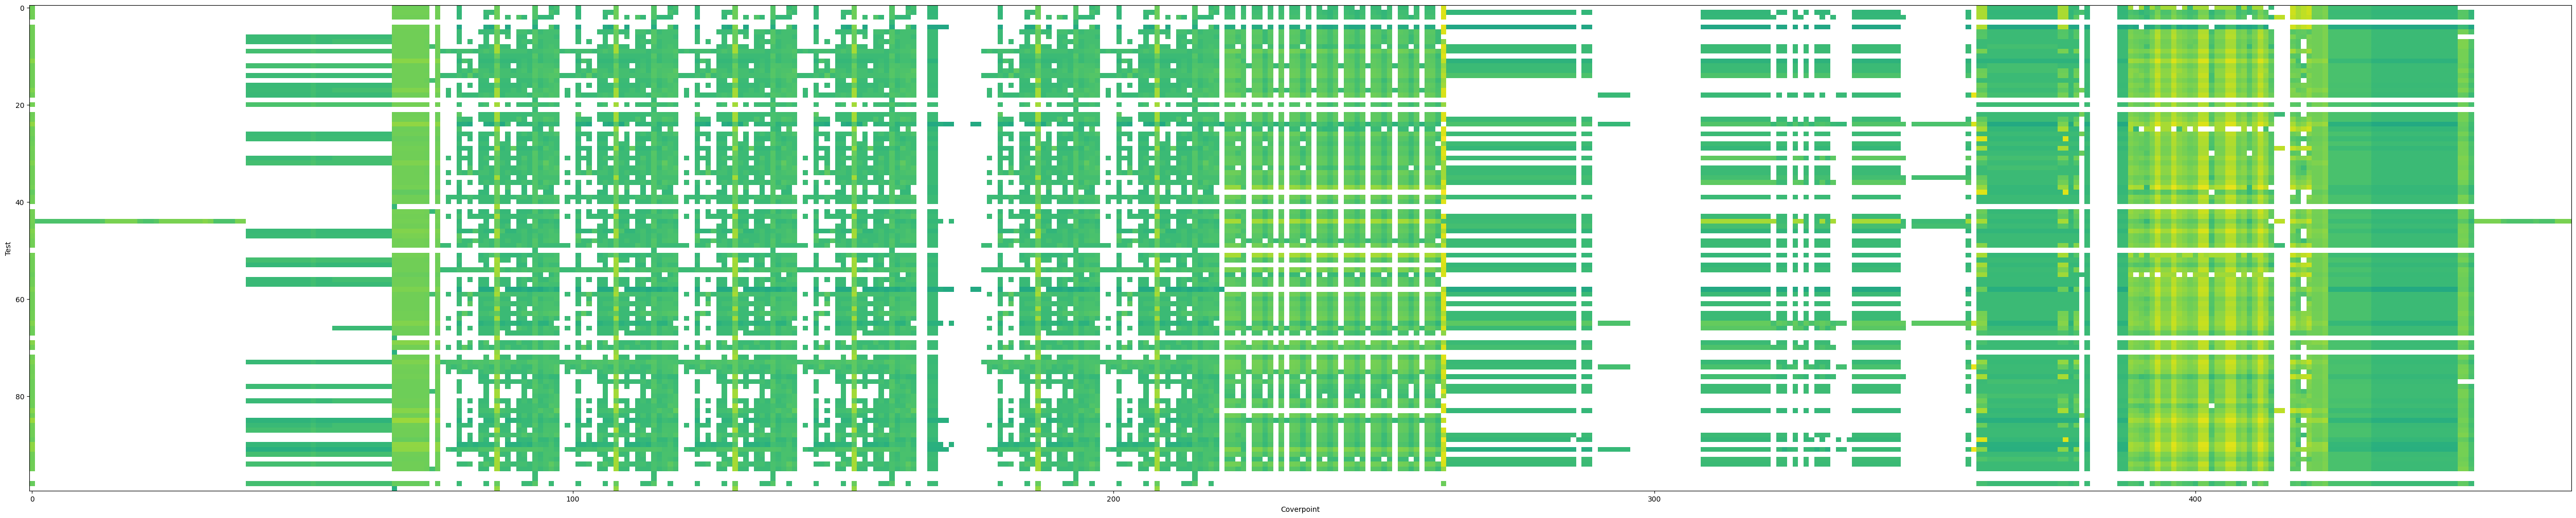

In [213]:
# Plot a heatmap
fig, ax = plt.subplots()
im = ax.imshow(B_norm[:100,:], vmin=0, vmax=np.nanmax(B_norm), norm="log", aspect='auto')
fig.set_figheight(10)
fig.set_figwidth(50)
fig.tight_layout()
ax.set_xlabel("Coverpoint")
ax.set_ylabel("Test")
plt.show()

In [216]:
# Look at the SVD for correlations
pca = PCA()
pca.fit(B_norm)

PCA()

In [222]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
#plt.plot(pca.singular_values_)
#plt.xlabel('Singular Value')
#plt.ylabel('Value')

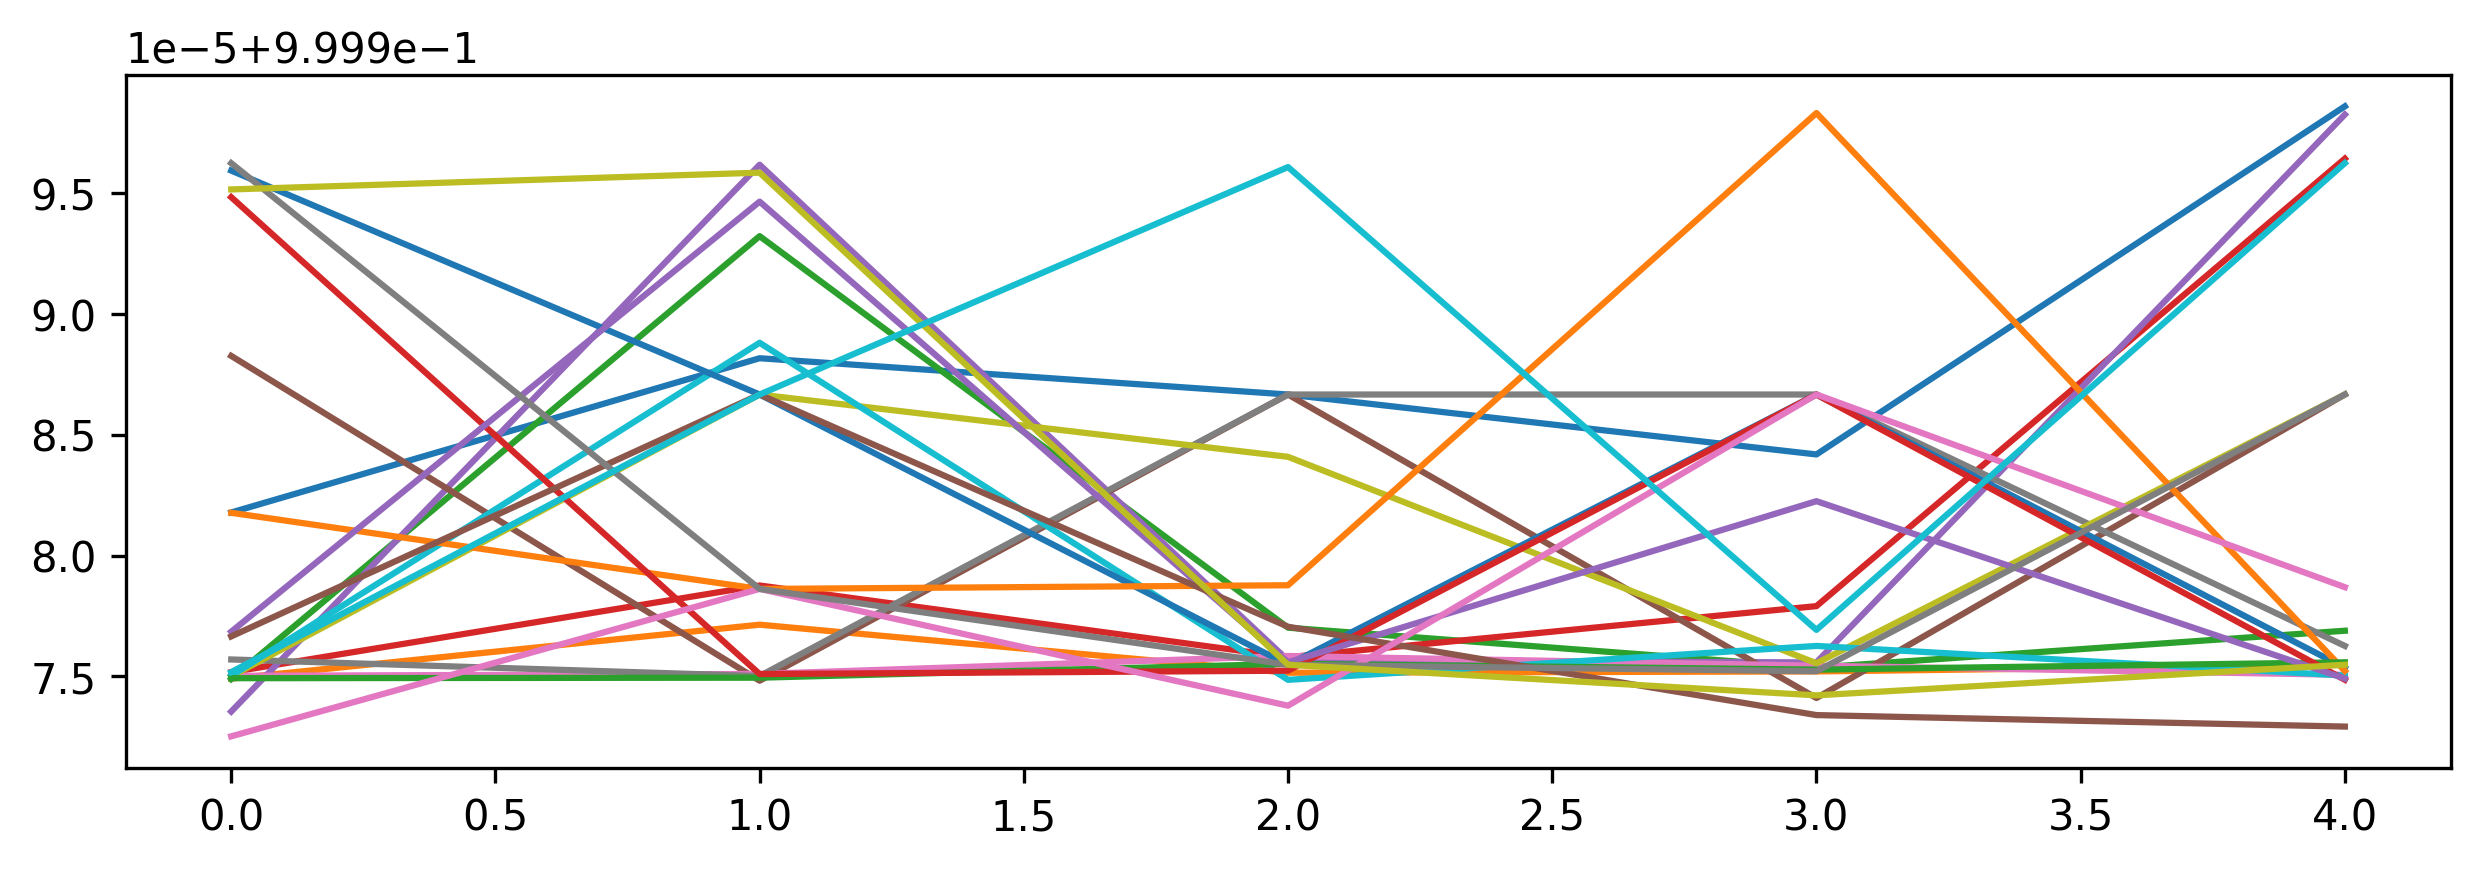

In [324]:
# Analyze the variance of the coverage data for a given coverpoint across different seeds of the same test config (knob value set)
cp = B[:100,401]
for i in range(int(B.shape[0] / 5)):
    plt.plot(cp[i*5:i*5+5])

In [257]:
# Test/train split
A_train, A_test, B_train, B_test = train_test_split(A, B_pruned, test_size=0.2, random_state=1, shuffle=True)

In [258]:
# Train linear regressor
linreg_pipe = make_pipeline(StandardScaler(), LinearRegression())
linreg_pipe.fit(A_train, B_train)
linreg_pipe.score(A_test, B_test)

-0.9202890750759248

In [259]:
# Train ridge regressor
ridgereg_pipe = make_pipeline(StandardScaler(), Ridge())
ridgereg_pipe.fit(A_train, B_train)
ridgereg_pipe.score(A_test, B_test)

-0.9151314503307291

In [260]:
# Analyze coefficients
idx = 402 #len(final_cov_data)-1
print(final_cov_data[idx])
max_coef = np.argmax(ridgereg_pipe.steps[1][1].coef_[idx,:])
min_coef = np.argmin(ridgereg_pipe.steps[1][1].coef_[idx,:])
print(max_coef)
print(min_coef)

keys = [x for x in cleaned_data[0].config.plusarg_config.keys() if x != "boot_mode"]
keys.sort()
print(keys[max_coef])
print(keys[min_coef])

('/nscratch/vighneshiyer/cov-proxy-model/rocket-chip/emulator/generated-src/freechips.rocketchip.system.DefaultRV32Config.v', 67144, 'MulDiv', 'else', 'TOP.TestHarness.ldut.tile_prci_domain.tile_reset_domain_tile.core.div', 0.0033518535385736407)
30
48
no_branch_jump
set_mstatus_mprv


In [ ]:
# Analyze ridge regressor error
ridgereg_pred = ridgereg_pipe.predict(A_test)
errors = np.fabs(ridgereg_pred - B_test).mean(axis=0)
B_train_class = np.copy(B_train)
B_train_class[np.nonzero(B_train_class)] = 1
#print(B_train_class.sum(axis=0))
seen_frequency = B_train_class.sum(axis=0) # number of training tests that saw this coverpoint
plt.rcParams["figure.figsize"] = (10,3)
plt.scatter(seen_frequency, errors, s=2)
plt.xlabel('Frequency a coverpoint has been seen in the training set')
plt.ylabel('Prediction error ln(hits/cycle)')
plt.yscale('log')
print(errors.mean())

0.00040467045336174754


In [322]:
# Train xgboost regressor
bst = xgboost.XGBRegressor()
bst.fit(A_train, B_train[:,400])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [323]:
bst.score(A_test, B_test[:,400])

0.22600072556091566

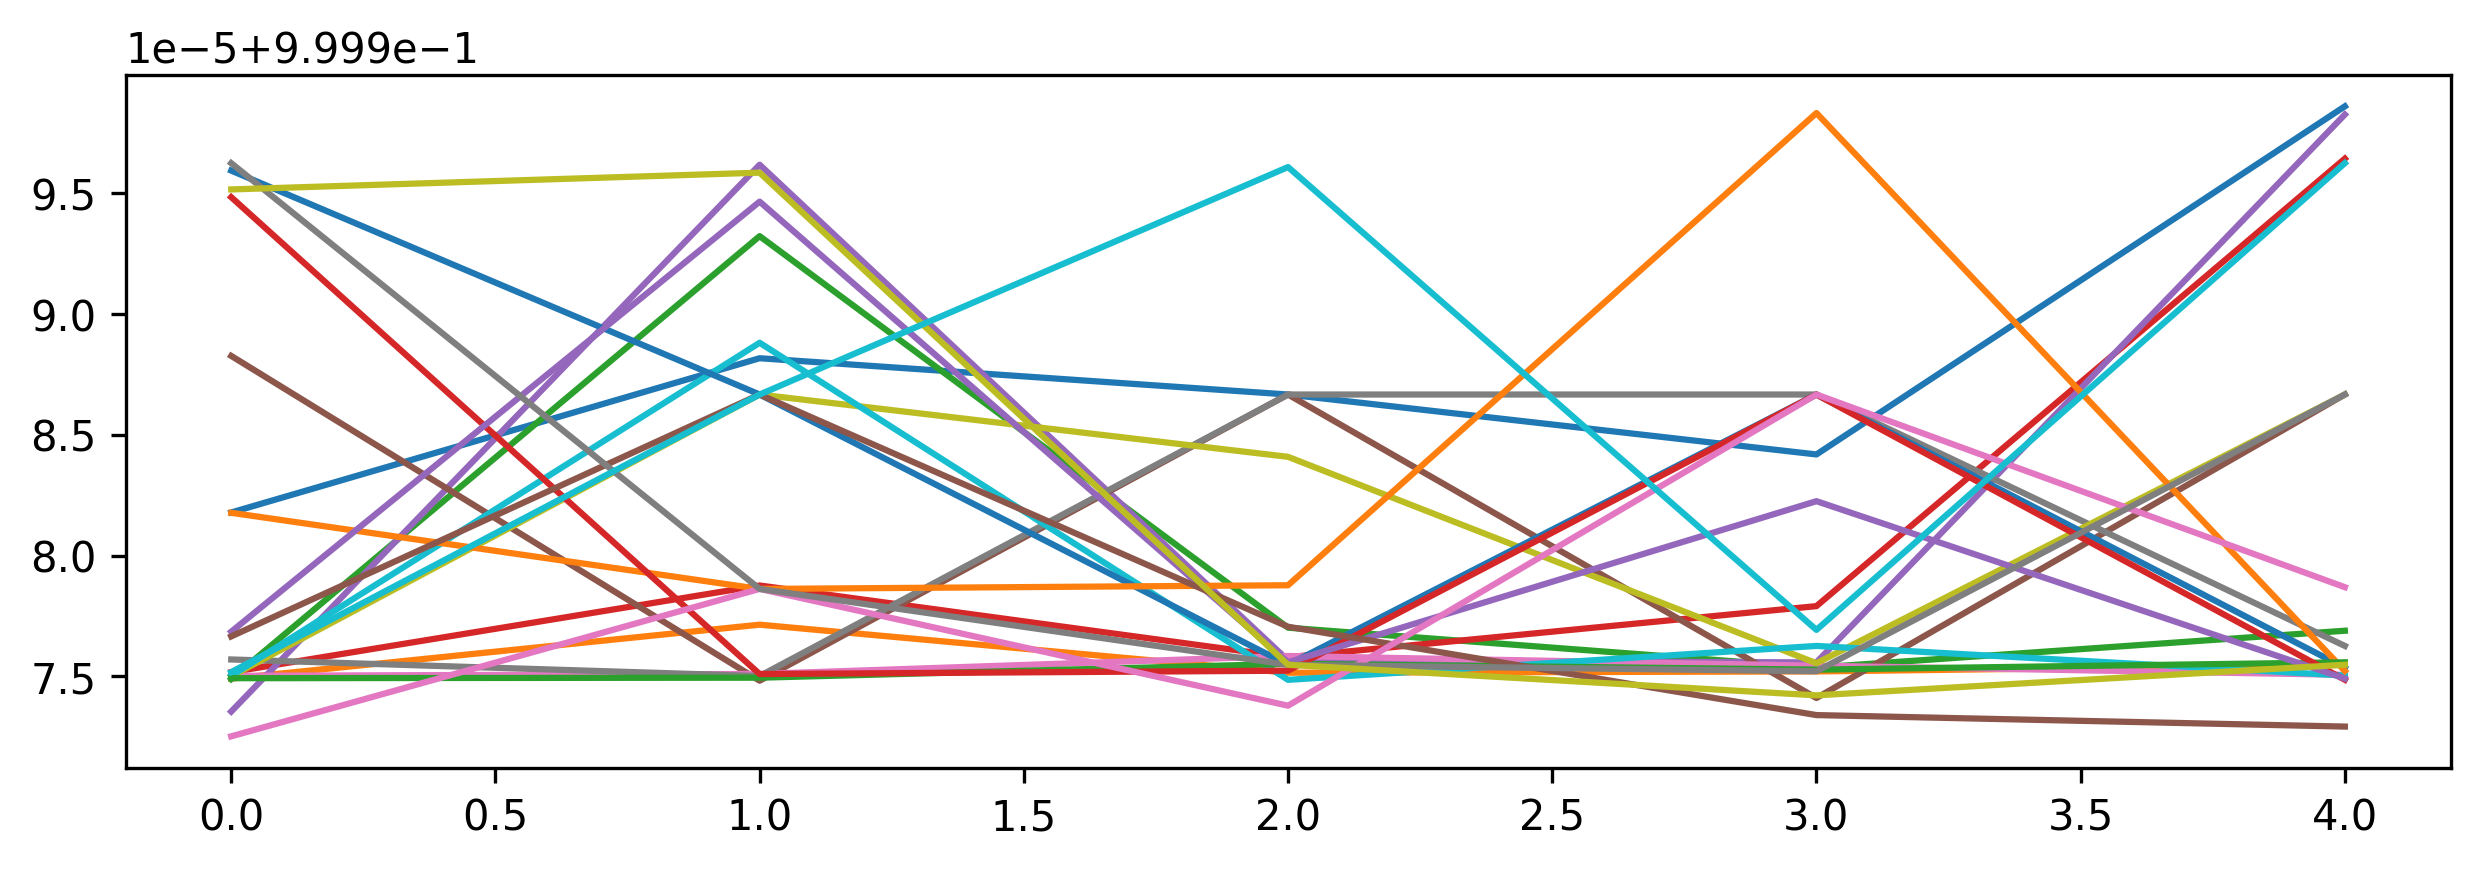